In [1]:
!python -m pip -q install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip -q install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install git+https://github.com/facebookresearch/detectron2.git

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-8x71_gs6/pyyaml_1a141971845d460db365c237a2060648/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 184, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 200, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/dist.py", line 968, in run_command
          super().run_command(command)
        File "/op

In [2]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

detectron2 version: 0.6


In [3]:
import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

In [6]:
import json
import copy
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random

# Function to update category ids in annotations to 0 (binary fractured label)
def update_annotations(annotations, image_id_offset, annotation_id_offset):
    updated_annotations = copy.deepcopy(annotations)
    for annotation in updated_annotations:
        annotation["category_id"] = 1  # Set category to binary class "fractured"
        annotation["id"] += annotation_id_offset
        annotation["image_id"] += image_id_offset
    return updated_annotations

# Function to update the image paths for each dataset
def update_image_paths(images, base_path, image_id_offset):
    updated_images = copy.deepcopy(images)
    for image in updated_images:
        image["file_name"] = f"{base_path}/{image['file_name']}"  # Update file path
        image["id"] += image_id_offset  # Update image ID to avoid conflicts
    return updated_images

def add_dummy_annotations(coco_data):
    image_ids_with_annotations = {ann['image_id'] for ann in coco_data['annotations']}
    all_image_ids = {img['id'] for img in coco_data['images']}
    image_ids_without_annotations = all_image_ids - image_ids_with_annotations
    
    # Create dummy annotations for those images (background, i.e., no object)
    dummy_category_id = 0  # assuming "0" means background or no class
    annotation_id_offset = len(coco_data['annotations'])
    image_ids_without_annotations = random.sample(image_ids_without_annotations, len(image_ids_with_annotations))
    print(len(image_ids_with_annotations))
    for i, image_id in enumerate(image_ids_without_annotations):
        dummy_annotation = {
            'id': annotation_id_offset + i,
            'image_id': image_id,
            'category_id': dummy_category_id,
            'bbox': [0, 0, 0, 0],  # no object, so an empty bbox
            'area': 0,
            'iscrowd': 0
        }
        coco_data['annotations'].append(dummy_annotation)
    coco_data['categories'] = [{"id": 0, "name": "No fracture"}, {"id": 1, "name": "Fracture"}]
    return coco_data
    

Run for Kaggle dataset

In [ ]:
# Load the two COCO annotation files
with open('/kaggle/input/bone-fracture-detection-detection-coco-annots/train_annotations.coco.json', 'r') as f:
    coco_big = json.load(f)

with open('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json', 'r') as f:
    coco_fracAtlas = json.load(f)

# Paths where images are located for each dataset
big_image_path = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
fracAtlas_image_path = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'

# Create a new dictionary to hold the merged dataset
combined_coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "fractured"}],  # Only binary class label
}


# Merge images and annotations from the first dataset (coco_big)
image_id_offset = 0
annotation_id_offset = 0
combined_coco["images"].extend(update_image_paths(coco_big["images"], big_image_path, image_id_offset))
combined_coco["annotations"].extend(update_annotations(coco_big["annotations"], image_id_offset, annotation_id_offset))

# Update offsets to avoid conflicts in image and annotation IDs
image_id_offset = len(coco_big["images"])
annotation_id_offset = len(coco_big["annotations"])

# Merge images and annotations from the second dataset (coco_fracAtlas)
combined_coco["images"].extend(update_image_paths(coco_fracAtlas["images"], fracAtlas_image_path, image_id_offset))
combined_coco["annotations"].extend(update_annotations(coco_fracAtlas["annotations"], image_id_offset, annotation_id_offset))

# non_fracAtlas_image_path = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Non_fractured'
# image_id_offset = len(combined_coco["images"])
# non_fractured_images = []
# for i, image_path in enumerate(Path(non_fracAtlas_image_path).glob("*.jpg")):
#     image = cv2.imread(image_path)
#     image_info = {
#         "id": image_id_offset + i,
#         "file_name": f"{non_fracAtlas_image_path}/{image_path.name}",
#         "width": image.shape[1],
#         "height": image.shape[0],
#     }
#     non_fractured_images.append(image_info)

# combined_coco["images"].extend(non_fractured_images)

add_dummy_annotations(combined_coco)

# Save the combined dataset as a new JSON file
with open('combined_annotations.coco.json', 'w') as f:
    json.dump(combined_coco, f)

print("Combined COCO dataset with updated image paths created successfully!")

Run for Custom data

In [7]:
import json
import copy
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the two COCO annotation files
with open('/kaggle/input/augmented-fracture-data/train/_annotations.coco.json', 'r') as f:
    coco_big = json.load(f)

# Paths where images are located for each dataset
# big_image_path = '/kaggle/input/augmented-fracture-data/train'

# # Create a new dictionary to hold the merged dataset
# combined_coco = {
#     "images": [],
#     "annotations": [],
#     "categories": [{"id": 0, "name": "fractured"}],  # Only binary class label
# }

# # Merge images and annotations from the first dataset (coco_big)
# image_id_offset = 0
# annotation_id_offset = 0
# combined_coco["images"].extend(update_image_paths(coco_big["images"], big_image_path, image_id_offset))
# combined_coco["annotations"].extend(update_annotations(coco_big["annotations"], image_id_offset, annotation_id_offset))

# # Update offsets to avoid conflicts in image and annotation IDs
# image_id_offset = len(coco_big["images"])
# annotation_id_offset = len(coco_big["annotations"])

add_dummy_annotations(coco_big)

# Save the combined dataset as a new JSON file
with open('combined_annotations.coco.json', 'w') as f:
    json.dump(coco_big, f)

print("Combined COCO dataset with updated image paths created successfully!")

/tmp/ipykernel_227/3626821019.py:33: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  image_ids_without_annotations = random.sample(image_ids_without_annotations, len(image_ids_with_annotations))


7650
Combined COCO dataset with updated image paths created successfully!


In [8]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

register_coco_instances(f"bone_fractures_big", {},
                            '/kaggle/working/combined_annotations.coco.json',
                            '/kaggle/input/augmented-fracture-data/train')

In [9]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_big")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_big")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
#     np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        print(img_link)
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [10/30 17:10:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/30 17:10:01 d2.data.datasets.coco]: Loaded 20633 images in COCO format from /kaggle/working/combined_annotations.coco.json


/kaggle/input/augmented-fracture-data/train/IMG0003171_jpg.rf.94f89a19c68623c25960f7605b799443.jpg
/kaggle/input/augmented-fracture-data/train/image1_1836_png_jpg.rf.b400c448127e3b2f63fb2d0a9a2b3d45.jpg
/kaggle/input/augmented-fracture-data/train/IMG0000499_jpg.rf.fc5c8ea1e4e2a44fd198e067a7f37ee0.jpg
/kaggle/input/augmented-fracture-data/train/image1_4521_png_jpg.rf.3132b216919f8a46cf7ab7b3b063cdce.jpg


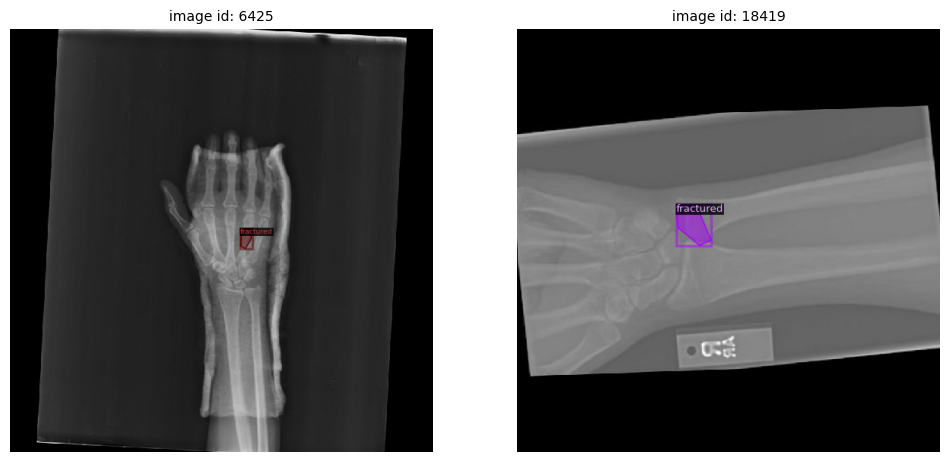

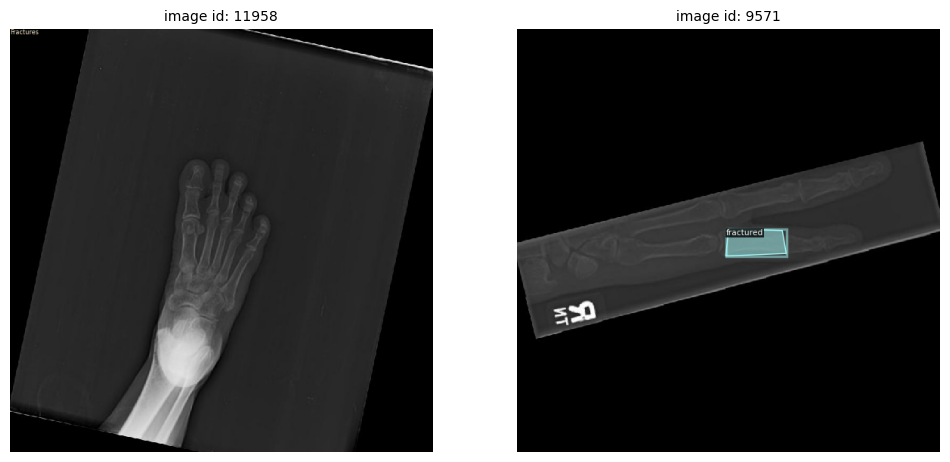

In [14]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 43 )
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 46 )

In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 2000
NUM_CLASSES = 2
BASE_LR = 0.0005

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_big")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

In [ ]:
def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [ ]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

In [ ]:
register_coco_instances(f"bone_fractures_val", {},
                            '/kaggle/input/bone-fracture-detection-detection-coco-annots/valid_annotations.coco.json',
                            '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images')


my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_val")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_val")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata,seed, image_scale = 0.8):
#     np.randomseed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"), 0.2)
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

In [ ]:
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)